In [1]:
import itertools
import random
# import community
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.stats import ttest_1samp


In [2]:
## Part 1 - Modeling the NCAA College Football 2000 Network ##
G = nx.read_gml("football.gml")

# Print the number of nodes and edges

print(f"Number of Nodes:\t{G.number_of_nodes()}")
print(f"Number of Edges:\t{G.number_of_edges()}")



Number of Nodes:	115
Number of Edges:	613


### 1.1 Structural Properties of the Graph


In [3]:
def hist_discrete(seq, density=False, ax=None):
    counts = Counter(seq)
    min_x = min(counts)
    max_x = max(counts)
    n = sum(counts.values())
    x = np.arange(min_x, max_x+1)
    y = [counts[i]/(n if density else 1) if i in counts else 0 for i in x]
    if ax is None:
        fig = plt.figure(figsize=(9, 6))
        ax = plt
        ax.set_xticks = plt.xticks
    ax.bar(x,y)
    ax.set_xticks(x, labels=x)
    return ax


     

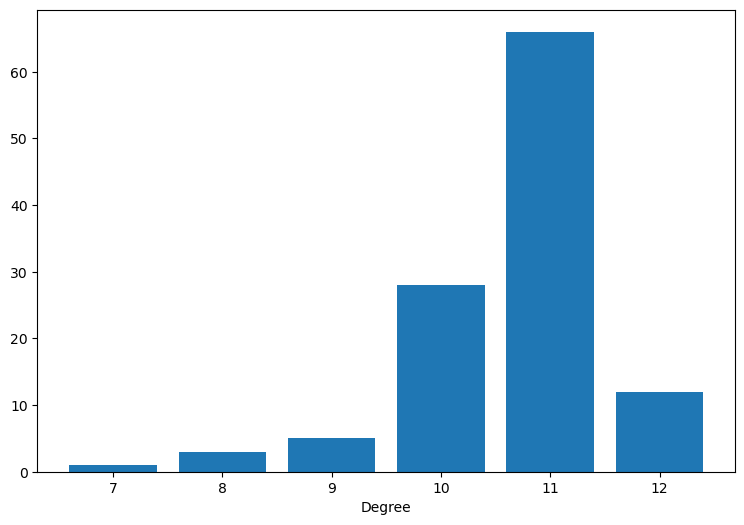

In [4]:
# Plot the degree distribution using histogram.
degrees = G.degree()
deg_sequence = dict(degrees).values()
hist_discrete(deg_sequence)
plt.xlabel("Degree");


In [5]:

def entropy(x):
    if len(x) == 0:
        return 0
    
    idx = np.unique(x, return_inverse=True)[1]
    pi = np.bincount(idx).astype(np.float64)
    pi = pi[pi > 0]

    # single cluster => zero entropy
    if pi.size == 1:
        return 0.0
    
    pi_sum = np.sum(pi)
    
    # log(a / b) should be calculated as log(a) - log(b) for
    # possible loss of precision
    return -np.sum((pi / pi_sum) * (np.log(pi) - np.log(pi_sum)))

def mutual_information(a, b):
    a = np.array(a)
    b = np.array(b)
    sum_mi = 0.0
    a_value_list = np.unique(a)
    b_value_list = np.unique(b)
    Pa = np.array([ len(a[a==aval])/float(len(a)) for aval in a_value_list ]) #P(a)
    Pb = np.array([ len(b[b==bval])/float(len(b)) for bval in b_value_list ]) #P(b)
    for i in range(len(a_value_list)):
        if Pa[i] ==0.:
            continue
        sb = b[a == a_value_list[i]]
        if len(sb)== 0:
            continue
        pab = np.array([len(sb[sb==bval])/float(len(b))  for bval in b_value_list]) #p(a,b)
        t = pab[Pb>0.]/Pb[Pb>0.] /Pa[i] # log(P(a,b)/( P(a)*P(b))
        sum_mi += sum(pab[t>0]*np.log( t[t>0]) ) # sum ( P(a,b)* log(P(a,b)/( P(a)*P(b)) )
    return sum_mi

def normalized_mutual_information(a, b):
    # Fill this portion with the code for NMI, Do not use anb librarb for directlb computing NMI,
    # bou are free to use math functions from the math librarb
    mi = mutual_information(a, b)
    h_a, h_b = entropy(a), entropy(b)
    normalizer = (h_a + h_b)/2
    return mi/normalizer


In [6]:
def parse_ground_truth(G):
    communities = dict()
    for (node, data) in G.nodes(data=True):
        communities.setdefault(data["value"], set())
        communities[data["value"]].add(node)
    return list(communities.values())

def community_sets_to_array(communities_sets):
    data = []
    for community, members in enumerate(communities_sets):
        for member in members:
            data.append((member, community))
    return [c for n, c in sorted(data)] # sort by node name



In [7]:
ground_truth_sets = parse_ground_truth(G)
ground_truth = community_sets_to_array(ground_truth_sets)
assert len(ground_truth) == G.number_of_nodes()



In [8]:
# Find the resolution parameter that leads to highest NMI.
highest_nmi = 0
best_r = None
best_soln = None
for r in np.arange(1, 11):
    communities = nx.community.louvain_communities(G, resolution=r, seed=42)
    comm_array = community_sets_to_array(communities)
    assert len(comm_array) == G.number_of_nodes()
    nmi = normalized_mutual_information(comm_array, ground_truth)
    if nmi > highest_nmi:
        highest_nmi = nmi
        best_soln = comm_array
        best_r = r
        
print(f"Best resolution parameter: {best_r}")
print(f"Highest NMI: {highest_nmi}")



Best resolution parameter: 2
Highest NMI: 0.9241952287164276


In [9]:
r = len(set(best_soln))
print(f"Number of communities r: {r}")

nodes = sorted(G.nodes())

p_matrix = np.zeros((r, r))
for i, c1 in enumerate(best_soln):
    node_i = nodes[i]
    for j, c2 in enumerate(best_soln):
        node_j = nodes[j]
        # check if there is an edge
        p_matrix[c1, c2] += int((node_i, node_j) in G.edges())

# normalize by community sizes
community_sizes = Counter(best_soln)
        
for c1, c1_size in community_sizes.items():
    for c2, c2_size in community_sizes.items():
        p_matrix[c1, c2] /= c1_size * c2_size

Number of communities r: 12


In [10]:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


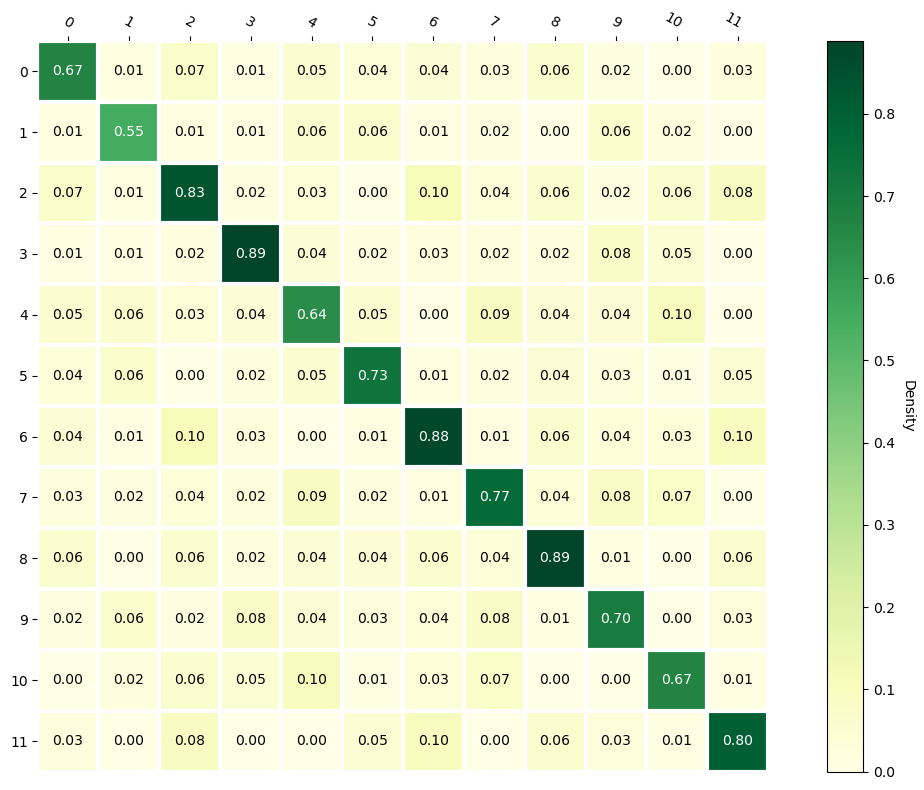

In [11]:
# Plot the inter-community connection density as heatmap.
fig, ax = plt.subplots(figsize=(12, 8))

axis_labels = np.arange(r)

im, cbar = heatmap(p_matrix, axis_labels, axis_labels, ax=ax,
                   cmap="YlGn", cbarlabel="Density")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()


In [13]:
def calculate_stats(G):
    diameter = nx.diameter(G) # network diameter
    cpl = nx.average_shortest_path_length(G) # CPL
    acc = nx.average_clustering(G) # average clustering coefficient
    trans = nx.transitivity(G) # transitivity
    assort = nx.assortativity.degree_assortativity_coefficient(G) # assortativity
    
    return diameter, cpl, acc, trans, assort


In [14]:
# Print the:
empirical_stats = calculate_stats(G)
diameter, cpl, acc, trans, assort = empirical_stats
# network diameter,
print(f"Network Diameter:\t{diameter}".expandtabs(36))
# characteristic path length (CPL),
print(f"Characteristic Path Length (CPL):\t{cpl}".expandtabs(36))
# average clustering coefficient,
print(f"Average Clustering Coefficient:\t{acc}".expandtabs(36))
# transitivity, and assortativity. 
print(f"Transitivity:\t{trans}".expandtabs(36))
print(f"Assocrtativity:\t{assort}".expandtabs(36))


Network Diameter:                   4
Characteristic Path Length (CPL):   2.5081617086193746
Average Clustering Coefficient:     0.40321601104209814
Transitivity:                       0.4072398190045249
Assocrtativity:                     0.16244224957444287


### 1.2 Configuration Model

In [15]:
metrics = ["Diameter", "CPL", "Average Clustering Coefficient", "Transitivity", "Assortativity"]
def plot_graphs_stats(graphs, show_ground_truth=False):
    # network diameter,
    diameter_seq = []
    # CPL,
    cpl_seq = []
    # average clustering coefficient,
    acc_seq = []
    # transitivity,
    trans_seq = []
    # assortativity. 
    assort_seq = []

    for g in graphs:
        diameter, cpl, acc, trans, assort = calculate_stats(g)
        diameter_seq.append(diameter)
        cpl_seq.append(cpl)
        acc_seq.append(acc)
        trans_seq.append(trans)
        assort_seq.append(assort)
        
    stats = [diameter_seq, cpl_seq, acc_seq, trans_seq, assort_seq]
    # Plot (Histogram /Boxplot)

    fig = plt.figure(figsize=(16, 9))
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
    ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
    ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
    ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
    ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

    ax = [ax1, ax2, ax3, ax4, ax5]
    for i, metric in enumerate(metrics):
        if i==0:
            hist_discrete(stats[i], ax=ax[i])
        else:
            ax[i].hist(stats[i])
        if show_ground_truth:
            ax[i].axvline(empirical_stats[i], color='red')
        ax[i].set_title(metric)
    
    fig.tight_layout(pad=3.0)
    return fig, (diameter_seq, cpl_seq, acc_seq, trans_seq, assort_seq)


In [16]:

# Generate Graphs
graphs_1_2 = [nx.configuration_model(deg_sequence=deg_sequence, create_using=nx.Graph()) for _ in range(100)]


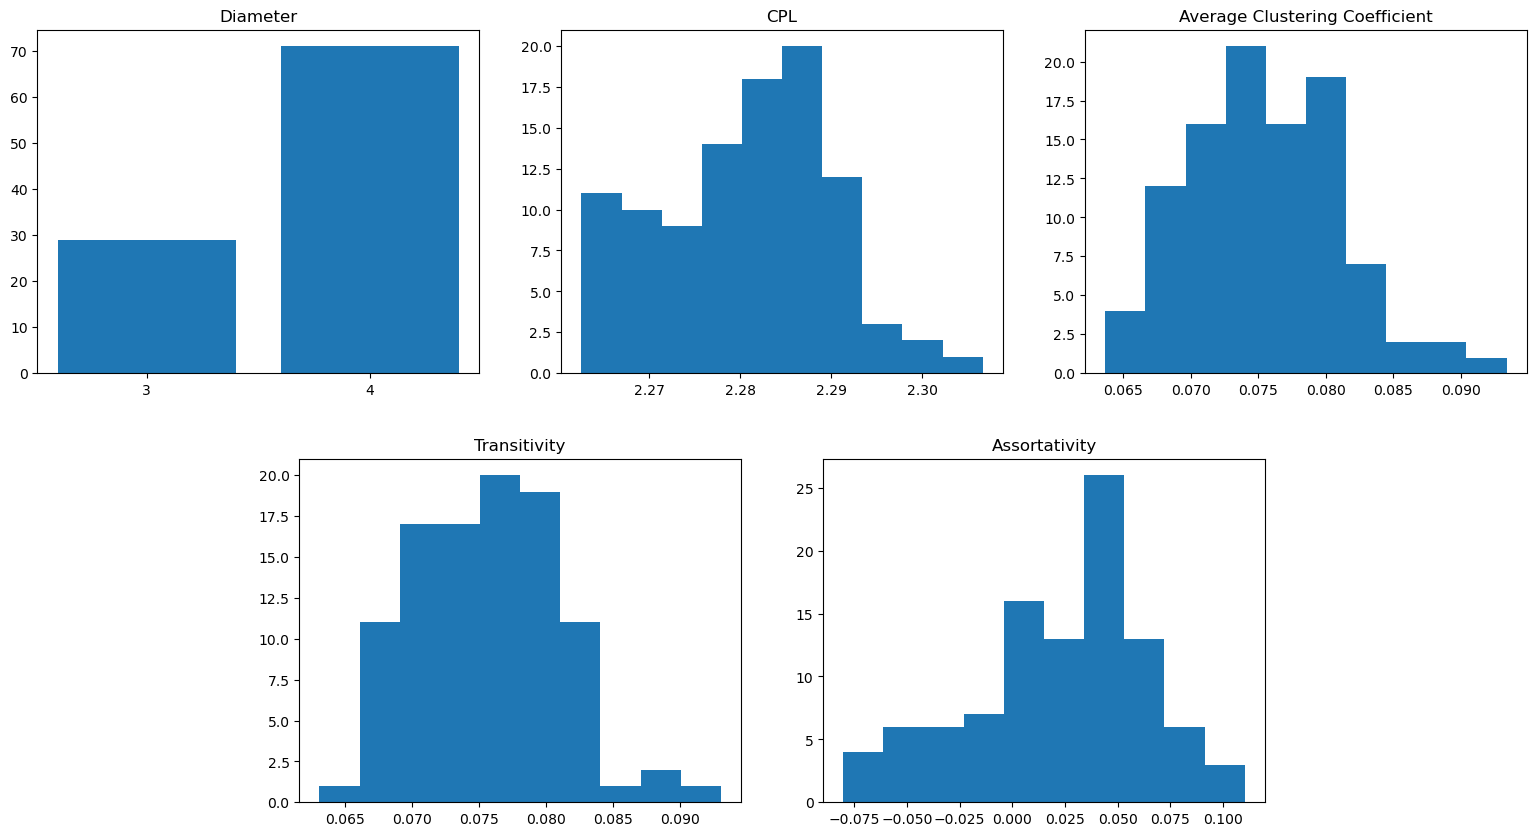

In [17]:
# Plot (Histogram /Boxplot):
# network diameter,
# CPL,
# average clustering coefficient,
# transitivity,
# assortativity. 

_, (diameters_1_2, cpl_1_2, acc_1_2, trans_1_2, assort_1_2) = plot_graphs_stats(graphs_1_2);


### 1.3 Stochastic Block Model Graphs

In [18]:

# Generate Graphs
graphs_1_3 = [nx.stochastic_block_model(sizes=[community_sizes[i] for i in range(r)], p=p_matrix) for _ in range(100)]


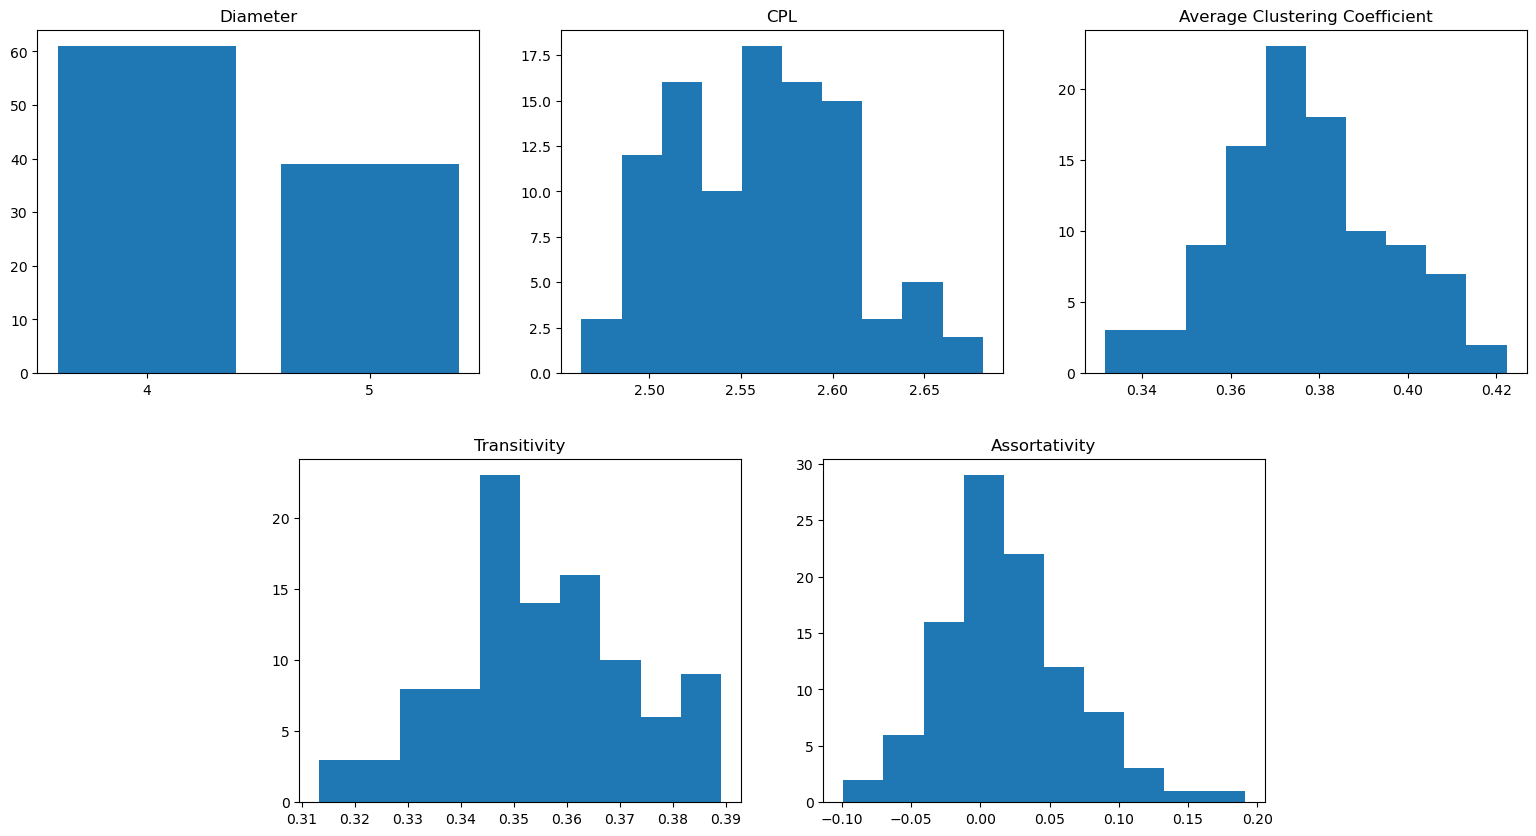

In [19]:
# Plot (Histogram /Boxplot):
# network diameter,
# CPL,
# average clustering coefficient,
# transitivity,
# assortativity. 

_, (diameters_1_3, cpl_1_3, acc_1_3, trans_1_3, assort_1_3) = plot_graphs_stats(graphs_1_3);


### 1.4 Hierarchical Random Graphs

In [20]:
dendrogram = nx.read_gml("football-hrg.gml")

In [21]:
# Generate Graphs
leaf_nodes = {node for node, degree in dendrogram.out_degree() if degree==0}


In [22]:
class Tree:
    def __init__(self, node, left=None, right=None, p=None):
        self.node = node
        self.left = left
        self.right = right
        self.p = p

    def is_leaf(self):
        return self.left is None and self.right is None

    def extract_nodes(self):
        nodes = []
        queue = [self.left, self.right]
        while len(queue) > 0:
            subtree = queue.pop()
            if subtree.is_leaf():
                nodes.append(subtree)
            else:
                queue.append(subtree.left)
                queue.append(subtree.right)
        return nodes

    def children_edges(self):
        edges = []
        probabilities = []
        left_nodes = [self.left] if self.left.is_leaf() \
                                    else self.left.extract_nodes()
        right_nodes = [self.right] if self.right.is_leaf() \
                                    else self.right.extract_nodes()
        for u in left_nodes:
            for v in right_nodes:
                edges.append((u, v))
                probabilities.append(self.p)
                
        assert len(set(edges)) == len(edges)
        return edges, probabilities

    def __repr__(self):
        return self.node

In [23]:
node2tree = dict()
for node, data in dendrogram.nodes(data=True):
    node2tree.setdefault(node, Tree(node))
    node2tree[node].p = data["p"]
    
    left = data.get("left")
    right = data.get("right")
    if left:
        node2tree.setdefault(left, Tree(left))
        node2tree[node].left = node2tree[left]
    if right:
        node2tree.setdefault(right, Tree(right))
        node2tree[node].right = node2tree[right]


In [24]:
root_nodes = [node for node, degree in dendrogram.in_degree() if degree==0]
assert len(root_nodes) == 1
root = node2tree[root_nodes.pop()]
assert len(root.extract_nodes()) == len(leaf_nodes)
root


_D0

In [25]:
# Generate graphs

def generate_graph():
    graph_edges = list()
    for node in node2tree.values():
        if not node.is_leaf():
            edges, probs = node.children_edges()
            for e, p in zip(edges, probs):
                assert e[0] != e[1] # avoid self-loops
                if np.random.random() < p:
                    graph_edges.append(e)
    return nx.Graph(graph_edges)



In [26]:
graphs_1_4 = [generate_graph() for _ in range(100)]

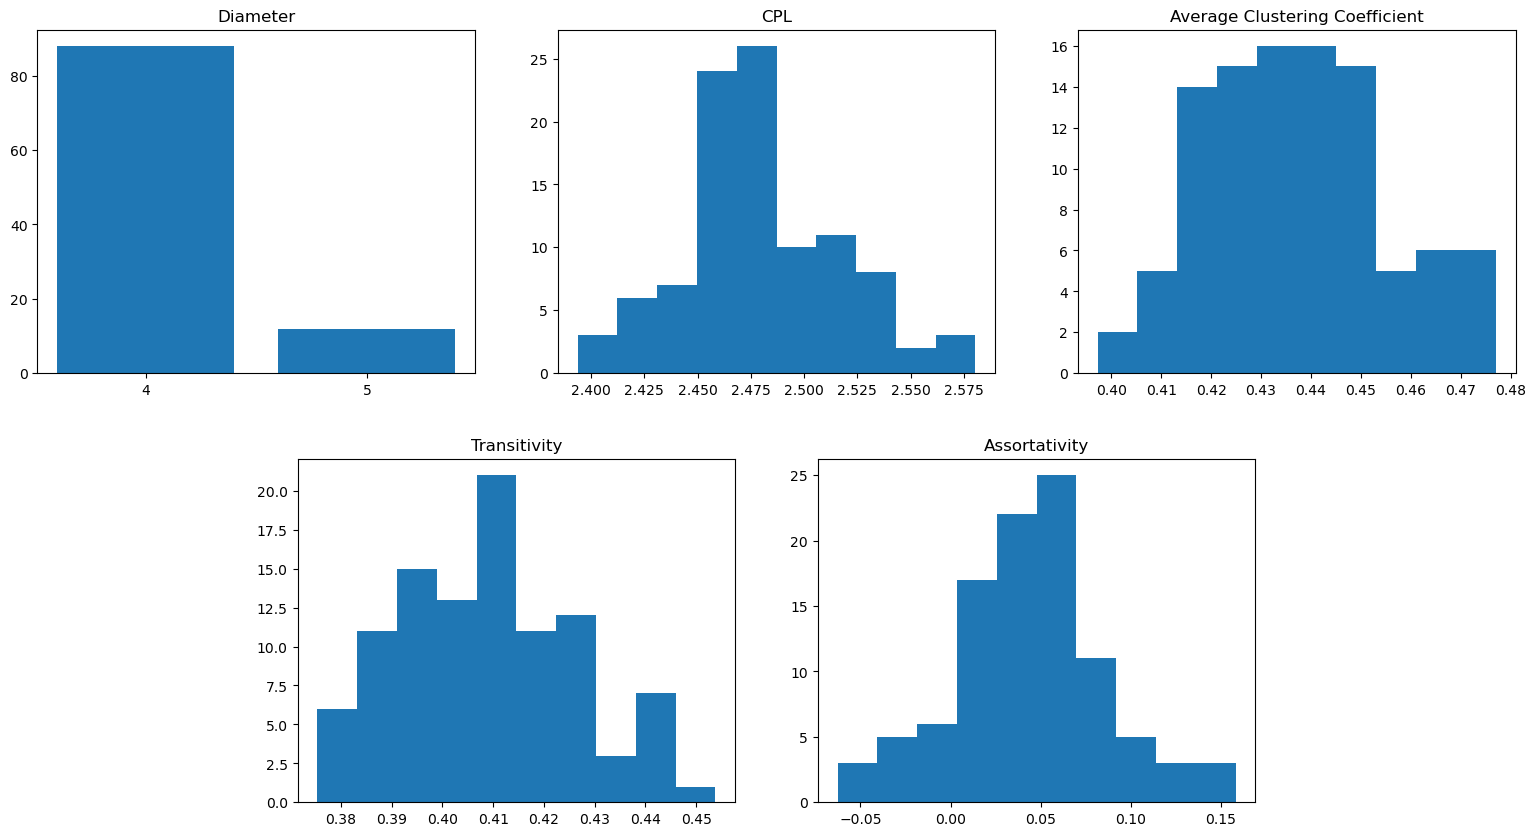

In [27]:
# Plot (Histogram /Boxplot):
# network diameter,
# CPL,
# average clustering coefficient,
# transitivity,
# assortativity. 

_, (diameters_1_4, cpl_1_4, acc_1_4, trans_1_4, assort_1_4) = plot_graphs_stats(graphs_1_4);



### 1.5 Best Fit

In [28]:
stats_data = np.array([
    (diameters_1_2, cpl_1_2, acc_1_2, trans_1_2, assort_1_2),
    (diameters_1_3, cpl_1_3, acc_1_3, trans_1_3, assort_1_3),
    (diameters_1_4, cpl_1_4, acc_1_4, trans_1_4, assort_1_4)
])

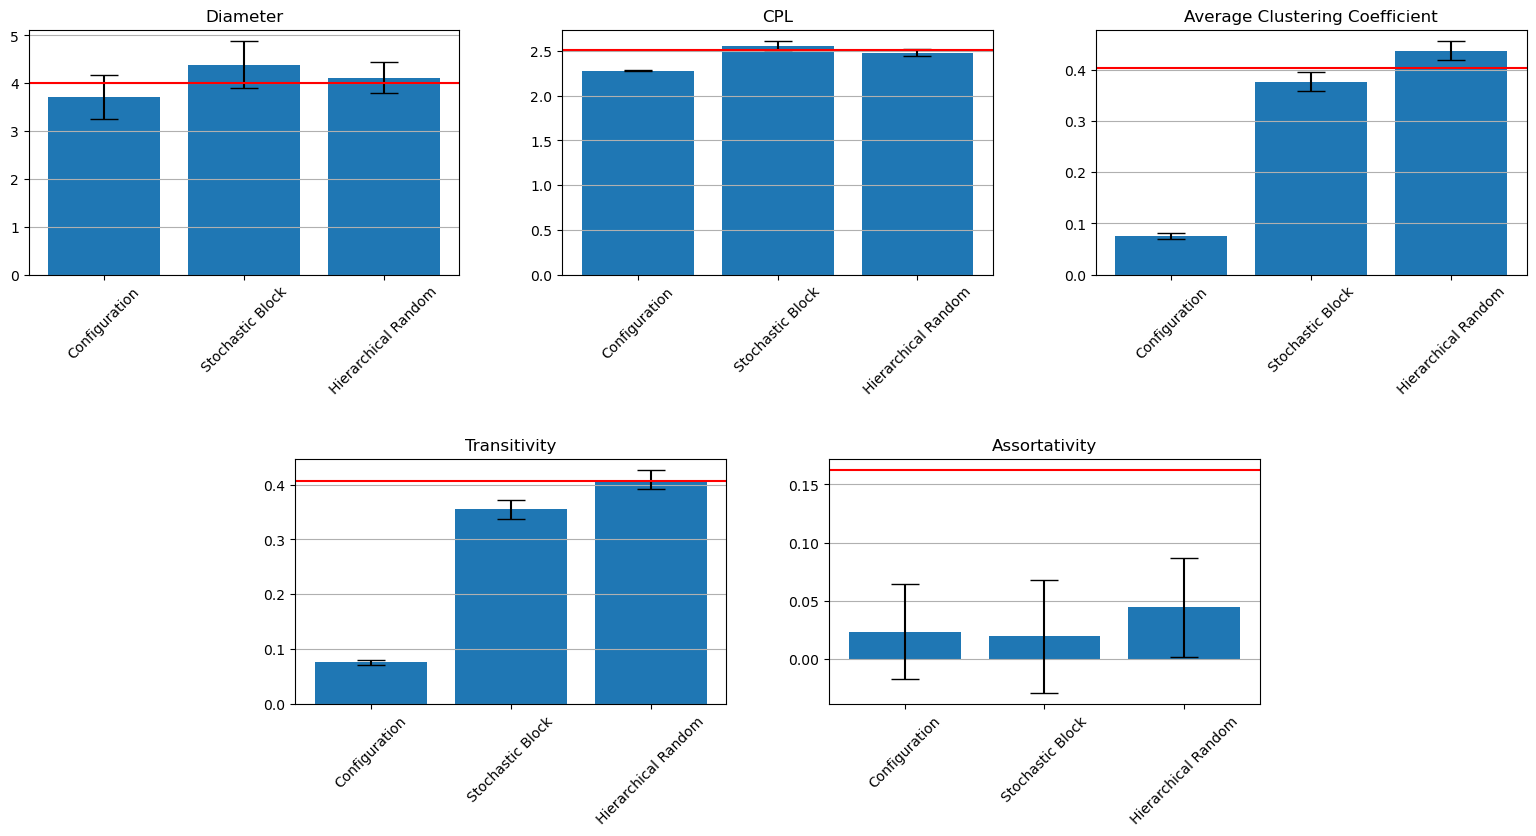

In [29]:
# BONUS : just trying to do a visual comparison here with the ground truth

fig = plt.figure(figsize=(16, 9))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

ax = [ax1, ax2, ax3, ax4, ax5]

x = ["Configuration", "Stochastic Block", "Hierarchical Random"]
xpos = np.arange(len(x))
for i, metric in enumerate(metrics):
    y = np.mean(stats_data[:, i], axis=1)
    yerr = np.std(stats_data[:, i], axis=1)
    ax[i].bar(xpos, y, yerr=yerr, ecolor='black', capsize=10)
    ax[i].set_xticks(xpos)
    ax[i].set_xticklabels(x, rotation=45)
    ax[i].yaxis.grid(True)
    ax[i].set_title(metric)
    ax[i].axhline(empirical_stats[i], color='red')

fig.tight_layout(pad=3.0)


In [30]:

# Configuration Model Graphs

for metric, values in zip(metrics, stats_data[0]):
    print(metric)
    print(f"Average: {np.mean(values)}\tStandrad Deviation: {np.std(values)}\n")
    
# Print the average value and standard deviation for:
# the diameter,
# CPL,
# average clustering coefficient,
# transitivity,
# assortativity 

Diameter
Average: 3.71	Standrad Deviation: 0.4537620521815371

CPL
Average: 2.280456140350877	Standrad Deviation: 0.009239258263905438

Average Clustering Coefficient
Average: 0.07541109228935311	Standrad Deviation: 0.005566533025728887

Transitivity
Average: 0.07543335983798738	Standrad Deviation: 0.005313450003243356

Assortativity
Average: 0.02340324626158198	Standrad Deviation: 0.04100506771069936



In [31]:
def hypothesis_test(sample, popmean):
    test = ttest_1samp(sample, popmean)
    return test.pvalue


In [32]:
# Hypothesis Tests
# Print the following
for i, metric in enumerate(metrics):
    print(metric)
    print(f"P-value: {hypothesis_test(stats_data[0, i], empirical_stats[i])}\n")
# P-Values for diameter,
# CPL,
# average clustering coefficient,
# transitivity,
# assortativity 

Diameter
P-value: 6.297222188581313e-09

CPL
P-value: 1.219254175647102e-139

Average Clustering Coefficient
P-value: 4.6116043034228445e-177

Transitivity
P-value: 1.3875630630880878e-179

Assortativity
P-value: 4.248674240121166e-56



In [33]:
# Stochastic Block Model Graphs
# Print the average value and standard deviation for:
for metric, values in zip(metrics, stats_data[1]):
    print(metric)
    print(f"Average: {np.mean(values)}\tStandrad Deviation: {np.std(values)}\n")
# the diameter,
# CPL,
# average clustering coefficient,
# transitivity,
# assortativity 

Diameter
Average: 4.39	Standrad Deviation: 0.487749935930288

CPL
Average: 2.5596628527841343	Standrad Deviation: 0.04719206504419437

Average Clustering Coefficient
Average: 0.3763571861410601	Standrad Deviation: 0.018401546280029553

Transitivity
Average: 0.35489664381365776	Standrad Deviation: 0.01714962235921553

Assortativity
Average: 0.01944256204673241	Standrad Deviation: 0.04835177090396678



In [34]:
# Hypothesis Tests
# Print the following
for i, metric in enumerate(metrics):
    print(metric)
    print(f"P-value: {hypothesis_test(stats_data[1, i], empirical_stats[i])}\n")

# P-Values for diameter,
# CPL,
# average clustering coefficient,
# transitivity,
# assortativity 

Diameter
P-value: 2.9842291905401545e-12

CPL
P-value: 1.4807672911800654e-18

Average Clustering Coefficient
P-value: 2.833115747098788e-26

Transitivity
P-value: 5.711129920416442e-52

Assortativity
P-value: 9.495957556900839e-51



In [35]:
# Hierarchical Random Graphs
for metric, values in zip(metrics, stats_data[2]):
    print(metric)
    print(f"Average: {np.mean(values)}\tStandrad Deviation: {np.std(values)}\n")
# Print the average value and standard deviation for:
# the diameter,
# CPL,
# average clustering coefficient,
# transitivity,
# assortativity 

Diameter
Average: 4.12	Standrad Deviation: 0.3249615361854385

CPL
Average: 2.479304347826087	Standrad Deviation: 0.0377278156696413

Average Clustering Coefficient
Average: 0.4370706421948849	Standrad Deviation: 0.018129658349176955

Transitivity
Average: 0.4084676250857139	Standrad Deviation: 0.017131442073255523

Assortativity
Average: 0.0442736406144729	Standrad Deviation: 0.04228717845322065



In [36]:
# Hypothesis Tests
# Print the following
for i, metric in enumerate(metrics):
    print(metric)
    print(f"P-value: {hypothesis_test(stats_data[2, i], empirical_stats[i])}\n")

# P-Values for diameter,
# CPL,
# average clustering coefficient,
# transitivity,
# assortativity 

Diameter
P-value: 0.0003873122498296595

CPL
P-value: 1.6229809229738644e-11

Average Clustering Coefficient
P-value: 4.83654648331496e-34

Transitivity
P-value: 0.47745837004237246

Assortativity
P-value: 1.4293967668324374e-48



In [67]:
# Which model do you think best approximates the empirical network? Explain your answer. 
print("Hierarchical Random Graphs seem to best appromixate the empirical network. " 
      "It is the only model which has one insignificant p-value : the Transitivity p-value is 0.477."
     "This means that at a 95% confidence interval we fail to reject the null hypothesis and conclude "
     "that the mean transitivity of the empirical network (which is 0.40) is not significantly different from the one obtained "
     "from the HRG model (which is 0.408).")

Hierarchical Random Graphs seem to best appromixate the empirical network. It is the only model which has one insignificant p-value : the Transitivity p-value is 0.477.This means that at a 95% confidence interval we fail to reject the null hypothesis and conclude that the mean transitivity of the empirical network (which is 0.40) is not significantly different from the one obtained from the HRG model (which is 0.408).


## Part 2

In [44]:
## Part 2 - Estimate the number of nodes and edges in Slashdot dataset ##
G = nx.read_edgelist("soc-Slashdot0902.txt", delimiter="\t", create_using=nx.DiGraph)
G.remove_edges_from(nx.selfloop_edges(G))

In [45]:
# Part 2.1
nodes = list(G.nodes())
def capture_recapture(G, sample_size=2000):
    capture = set(random.sample(nodes, sample_size))
    tag_ratio = 0
    trials = 0
    while tag_ratio == 0: # avoid miscaptures for insufficient sample size
        recapture = random.sample(nodes, sample_size)
        tag_ratio = len(set(recapture).intersection(capture))/len(recapture)
        trials += 1
        if trials > 10:
            return float('inf') # population seem to be too large to recapture any of the tagged samples
    
    return len(capture)/tag_ratio

In [47]:
def analysis(sample_size=2000, trials=1000):
    return [capture_recapture(G, sample_size=sample_size) for _ in range(trials)]


In [52]:
estimations = dict()
for sample_size in [500, 1000, 2000, 5000, 10_000]:
    estimations[sample_size] = analysis(sample_size=sample_size)

In [50]:
from decimal import Decimal

def format_big_number(number):
    if number >= 1e6:
        return f"{round(number/1e6, 2)}M"
    if number >= 1e3:
        return f"{round(number/1e3, 2)}K"
    return str(number)


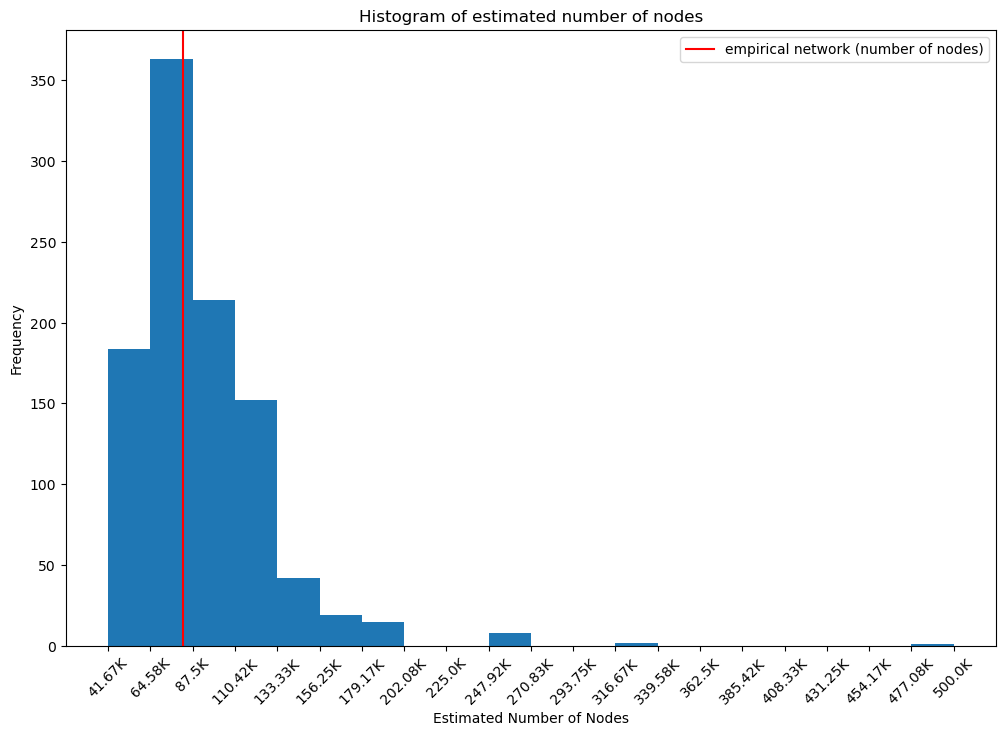

In [54]:
fig = plt.figure(figsize=(12, 8))
h = plt.hist(estimations[1000], bins=20)
xlabels = [format_big_number(x) for x in h[1]]
plt.xlabel("Estimated Number of Nodes")
plt.ylabel("Frequency")
plt.xticks(h[1], labels=xlabels, rotation=45)
plt.title("Histogram of estimated number of nodes")
plt.axvline(G.number_of_nodes(), color='red', label="empirical network (number of nodes)")
plt.legend();


In [55]:
# Part 2.2

x = []
y = []

x_grouped = []
means = []
std = []
for sample_size, est_pop_size in estimations.items():
    x_grouped.append(sample_size)
    x += [sample_size] * len(est_pop_size)
    y += est_pop_size
    
    means.append(np.mean(est_pop_size))
    std.append(np.std(est_pop_size))

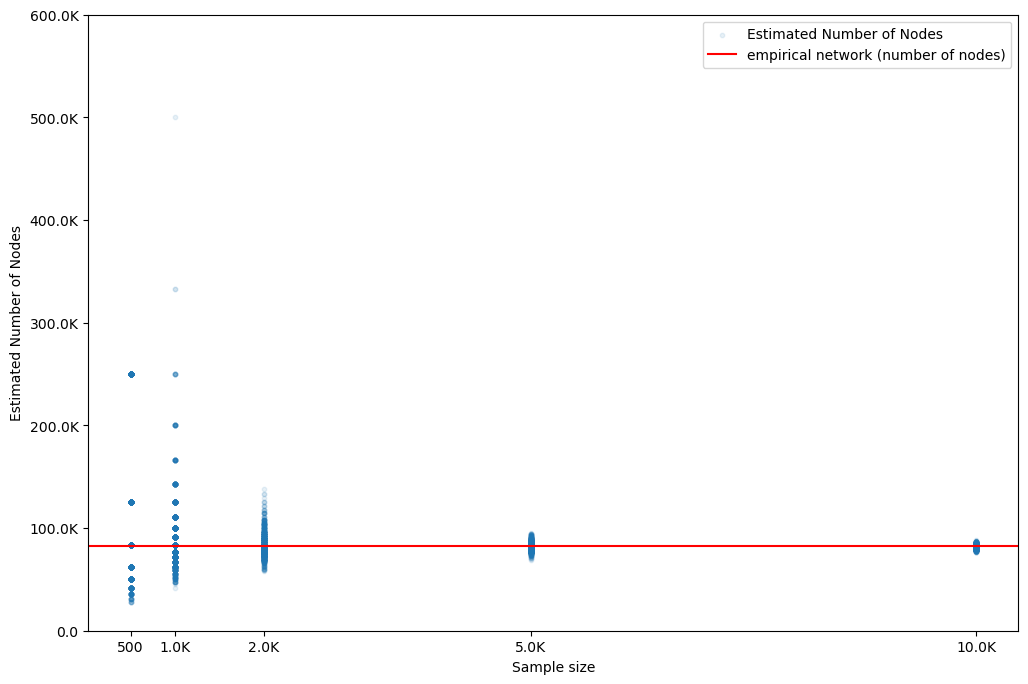

In [56]:
plt.figure(figsize=(12, 8))
xticks = list(estimations.keys())
xtick_labels = [format_big_number(x) for x in xticks]
plt.scatter(x, y, label="Estimated Number of Nodes", alpha=0.1, s=10)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[format_big_number(y) for y in yticks])

plt.xticks(xticks, labels=xtick_labels)
plt.axhline(G.number_of_nodes(), label="empirical network (number of nodes)", c="r")
plt.xlabel("Sample size")
plt.ylabel("Estimated Number of Nodes")
plt.legend();

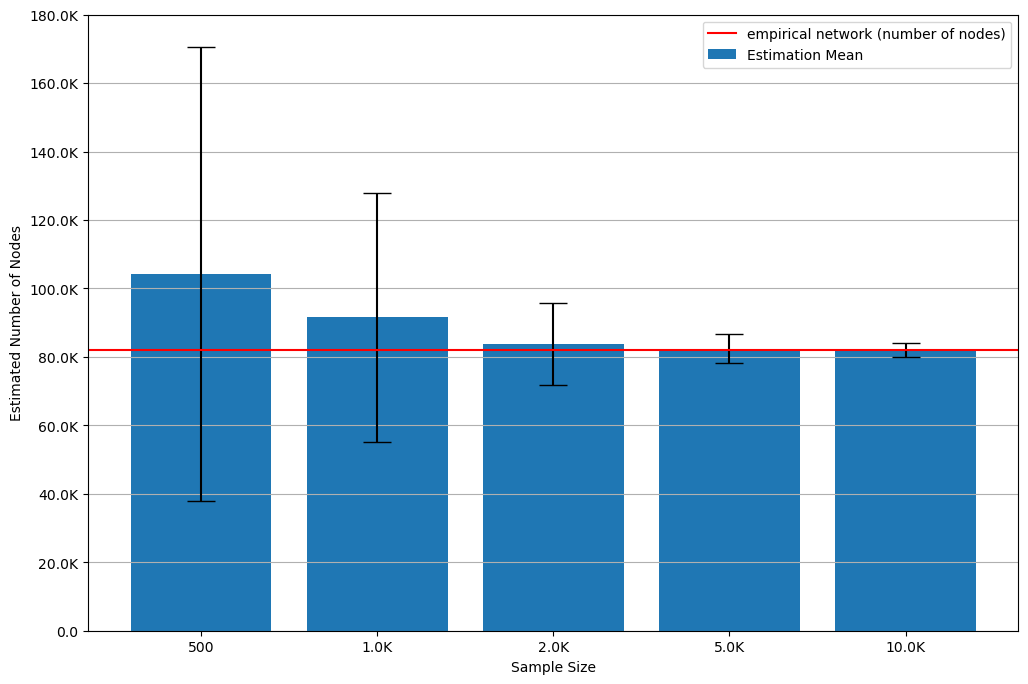

In [58]:
plt.figure(figsize=(12, 8))
plt.bar(xtick_labels, means, yerr=std, ecolor='black', capsize=10, label="Estimation Mean")
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[format_big_number(y) for y in yticks])
plt.axhline(G.number_of_nodes(), label="empirical network (number of nodes)", c="r")
plt.ylabel("Estimated Number of Nodes")
plt.grid(axis="y")
plt.xlabel("Sample Size")
plt.legend();


**Commentary**: From the two plots above, we can see that at lower sample sizes the mean of the estimated number of nodes is highly unstable (with a high standard deviation from the mean) and also higher than what is empirically observed. However, as we increase the sample size the mean of the estimated number of nodes and its standard deviation reduces and our estimate gets closer to the empirical value. 

In [27]:
# Part 2.3

In [64]:
def estimate_number_of_edges(sample_size=5000):
    sample_nodes = random.sample(nodes, sample_size)
    subgraph = nx.induced_subgraph(G, sample_nodes)
    n = sample_size
    N = G.number_of_nodes()
    inclusion_prob = (n * (n-1)) / (N*(N-1)) # all edges have same inclusion probability
    return subgraph.number_of_edges() / inclusion_prob # expected number of edges


In [65]:
number_of_edges = [estimate_number_of_edges() for _ in range(100)]  

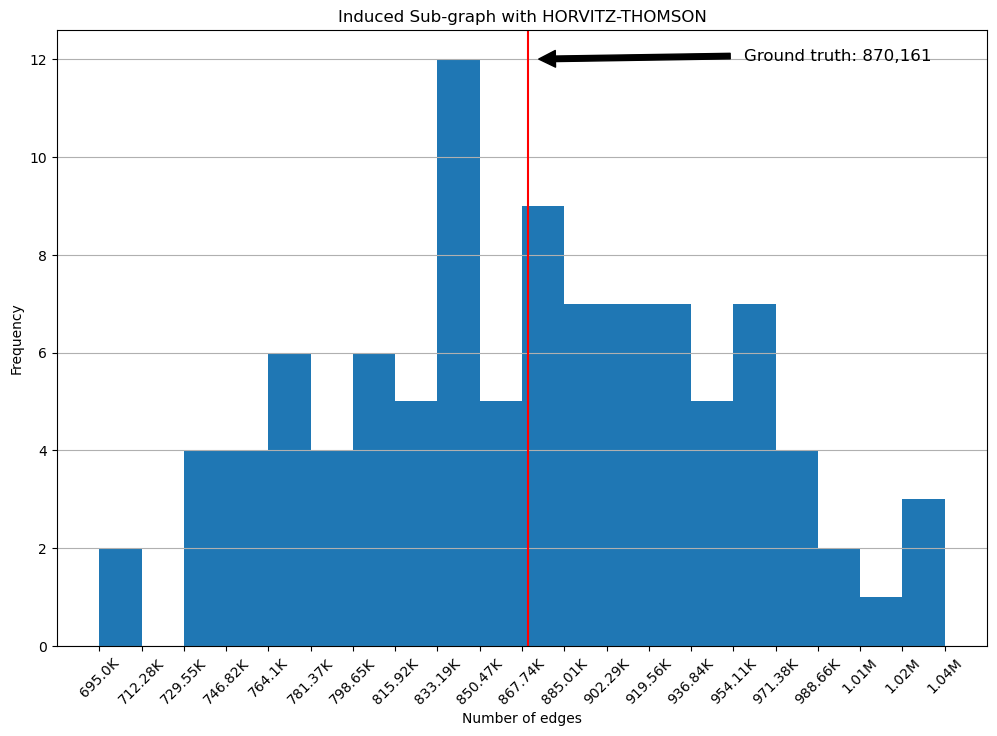

In [66]:
plt.figure(figsize=(12, 8))
h = plt.hist(number_of_edges, bins=20)
plt.annotate('Ground truth: {:,}'.format(G.number_of_edges()), fontsize=12,
             xy=(G.number_of_edges(), max(h[0])),  xycoords='data',
             xytext=(0.94, 0.97), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right', verticalalignment='top')


xticks = list(h[1])
xtick_labels = [format_big_number(x) for x in xticks]
plt.xticks(xticks, labels=xtick_labels, rotation=45)
plt.axvline(G.number_of_edges(), c="r")
plt.grid(axis="y")
plt.xlabel("Number of edges")
plt.title("Induced Sub-graph with HORVITZ-THOMSON")
plt.ylabel("Frequency");